In [1]:
import os, sys
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import anndata
import warnings
warnings.filterwarnings('ignore', category=anndata.ImplicitModificationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sys.path.insert(
    0,
    '/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/lib/utils'
)
from spatial.utils import getDefaultColors, removeBiasGenes, getDEG
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=100,dpi_save=300,frameon=False,facecolor='white',fontsize=12,vector_friendly=True,figsize=(5,5))
sc._settings.ScanpyConfig(figdir='./',n_jobs=30)

In [3]:
od = '/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/10.1_CAF_Macro_T_subtype_signature_TCGA_validation'
os.system(f'mkdir -p {od}')
os.chdir(od)

In [4]:
exp_mtx_tumor = pd.read_csv('/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/10.1_CAF_Macro_T_subtype_signature_TCGA_validation/mRNA_RSEM_UQ_log2_Tumor.cct',sep='\t',index_col=0)
exp_mtx_normal = pd.read_csv('/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/10.1_CAF_Macro_T_subtype_signature_TCGA_validation/mRNA_RSEM_UQ_log2_Normal.cct',sep='\t',index_col=0)
exp_mtx = pd.concat([exp_mtx_tumor,exp_mtx_normal],axis=1)

In [6]:
exp_mtx_tumor.columns

Index(['C3L-03394', 'C3N-03428', 'C3L-02112', 'C3N-01719', 'C3N-03670',
       'C3N-02998', 'C3N-03211', 'C3L-01052', 'C3N-00512', 'C3N-02295',
       ...
       'C3L-01031', 'C3N-01167', 'C3L-01971', 'C3L-02604', 'C3L-00277',
       'C3L-01328', 'C3L-03639', 'C3N-04282', 'C3L-04072', 'C3L-02613'],
      dtype='object', length=140)

In [9]:
metadata = pd.DataFrame(index=exp_mtx.columns)
# metadata add new column celltype, in exp_mtx_tumor, celltype is tumor, in exp_mtx_normal, celltype is normal
metadata['celltype'] = 'NA'
metadata.loc[exp_mtx_tumor.columns,'celltype'] = 'tumor'
metadata.loc[exp_mtx_normal.columns,'celltype'] = 'normal'


In [ ]:
# from mygene import MyGeneInfo
# genes = exp_mtx.index.tolist()
# # remove str after '.'
# genes = [i.split('.')[0] for i in genes]
# markers = []
# mg = MyGeneInfo()
# for gene in genes:
#     result = mg.query(gene, fields=["symbol"], species="human", verbose=False)
#     if len(result['hits']) > 0 and 'symbol' in result['hits'][0].keys():
#       markers.append(result['hits'][0]['symbol'])
#     else:
#       markers.append('unknown')


In [4]:
from ctxcore.genesig import *
import ctxcore


class GeneSignature2(ctxcore.genesig.GeneSignature):
  @classmethod
  def from_gmt(cls,
                fname: str,
                field_separator: str = "\t",
                gene_separator: str = "\t") -> List["GeneSignature"]:
      """
      Load gene signatures from a GMT file.

      :param fname: The filename.
      :param field_separator: The separator that separates fields in a line.
      :param gene_separator: The separator that separates the genes.
      :return: A list of signatures.
      """
      # https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats
      assert os.path.exists(fname), f'"{fname}" does not exist.'

      def signatures():
          with openfile(fname, "r") as file:
              for line in file:
                  if isinstance(line, (bytes, bytearray)):
                      line = line.decode()
                  if line.startswith("#") or not line.strip():
                      continue
                  name, genes_str = re.split(field_separator,
                                              line.rstrip(),
                                              maxsplit=2)
                  genes = genes_str.split(gene_separator)[:30]
                  yield GeneSignature(name=name, gene2weight=genes)

      return list(signatures())


sig_CAF = GeneSignature2.from_gmt(
    '/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/5.7_CAF_scRNA_monocle2/DEGs.txt',
    field_separator='\t',
    gene_separator=',')
sig_Macro = GeneSignature2.from_gmt('/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/8.5_sc_macro_monocle2/all/DEGs_subtype.txt',field_separator='\t', gene_separator=',')
sig_T = GeneSignature2.from_gmt('/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/9.4_sc_Tcell_monocle2/all/DEGs_subtype.txt',field_separator='\t', gene_separator=',')


In [133]:
CAF_list = ['Fibro_F2RL2','Fibro_USP53','Fibro_MME','Fibro_COL11A1']
Macro_list = ['Macro_SPP1_NMF_7_23','Macro_C3_NMF_11']
T_list = ['T_CD4NV_CM_rest_NMF_8','T_CD8_PRSS1_NMF_20']
sig_CAF_selected = [i for i in sig_CAF if i.name in CAF_list]
sig_Macro_selected = [i for i in sig_Macro if i.name in Macro_list]
sig_T_selected = [i for i in sig_T if i.name in T_list]
from pyscenic.aucell import aucell
auc_mtx = aucell(exp_mtx.T, sig_CAF_selected + sig_Macro_selected + sig_T_selected, noweights=True, num_workers=20)


In [134]:
auc_mtx['sample_type'] = metadata['celltype']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:5.370e-04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:5.774e-05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:9.933e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:1.585e-03
p-value annotation legend:
      ns: p <

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'F', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'a', 'asterisk', 'b', 'c', 'e', 'eight', 'five', 'four', 'glyph00001', 'glyph00002', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'underscore', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 17, 19, 20, 21, 22, 23, 24, 26

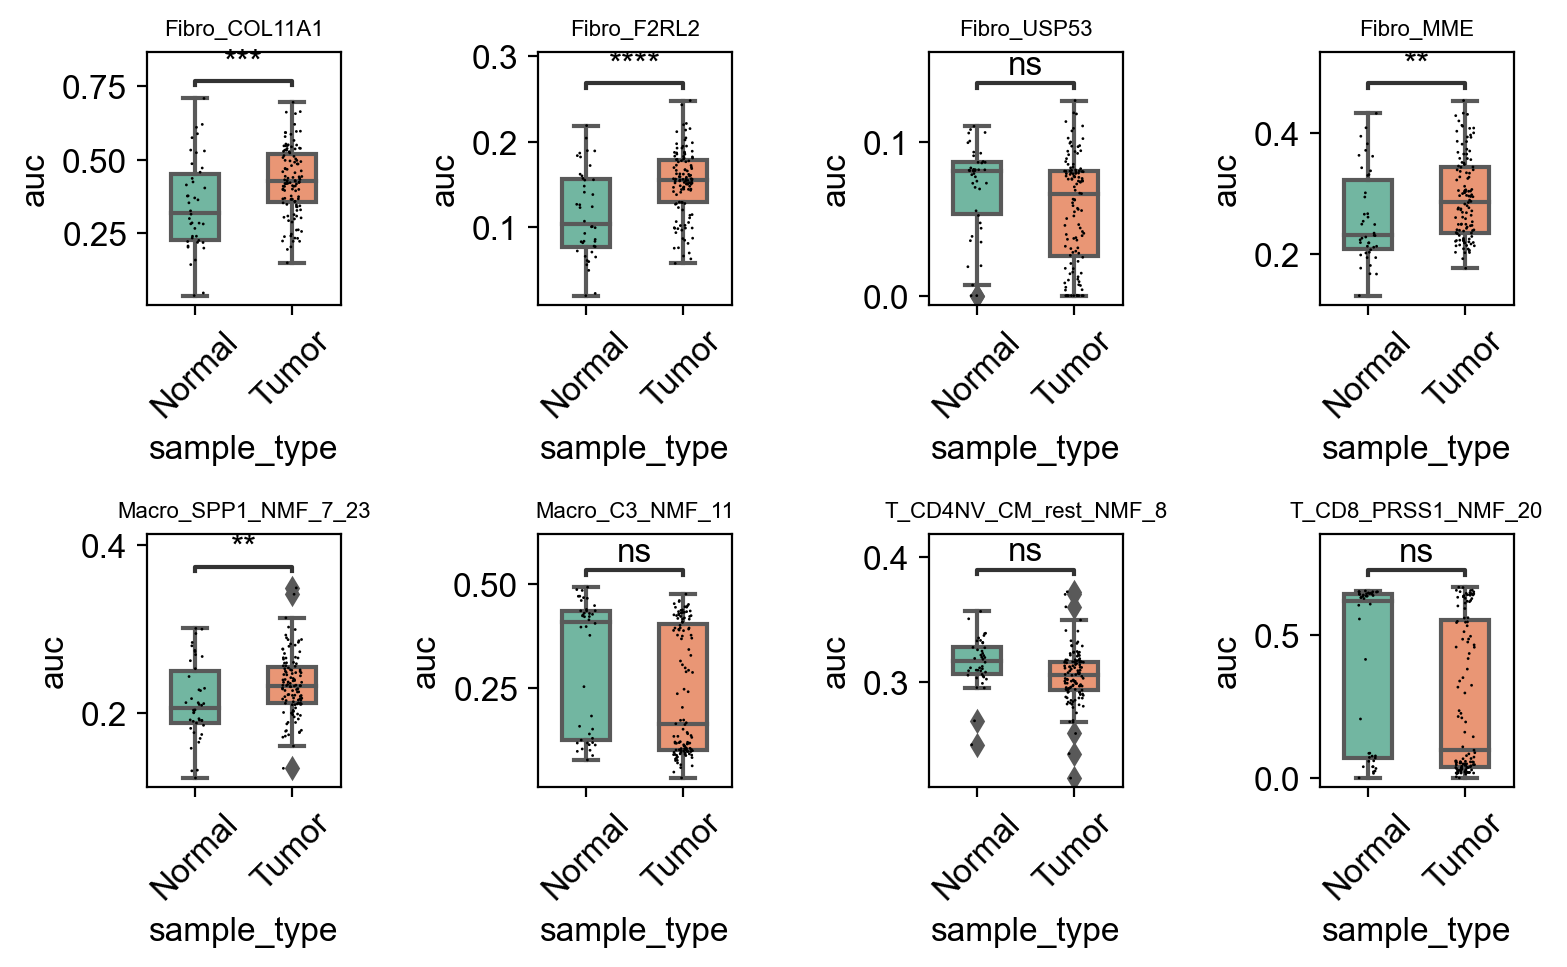

In [194]:
# draw boxplot to show the distribution of AUC score for each signature in each sample type
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind,mannwhitneyu

auc_mtx_melt = auc_mtx.melt(id_vars=['sample_type'],var_name='subtype',value_name='auc')
auc_mtx_melt['auc'] = auc_mtx_melt['auc'].astype(float)
auc_mtx_melt['sample_type'] = auc_mtx_melt['sample_type'].astype('category')
auc_mtx_melt['subtype'] = auc_mtx_melt['subtype'].astype('category')
# draw boxplot for each subtype,add stripplot and t.test pvalue
fig, axs = plt.subplots(2,4,figsize=(8,5))
for i, subtype in enumerate(auc_mtx_melt['subtype'].unique()):  
    axs_tmp = axs[i//4, i%4]
    auc_tmp = auc_mtx_melt[auc_mtx_melt['subtype'] == subtype]
    plotting_parameters = {
        'data':    auc_tmp,
        'x':       'sample_type',
        'y':       'auc'
    }   
    group_data = auc_tmp['auc'][auc_tmp['sample_type'] =='tumor']
    other_group_data = auc_tmp['auc'][auc_tmp['sample_type'] =='normal']
    _, p_val = mannwhitneyu(group_data, other_group_data, alternative="greater")
    formatted_pvalues = [f'p={p_val:.2e}']
    pairs = [('normal', 'tumor')]
    sns.boxplot(**plotting_parameters,ax=axs_tmp, palette='Set2',width=0.5)
    annotator = Annotator(axs_tmp, pairs, **plotting_parameters)
    annotator.set_pvalues([p_val])
    # annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    sns.stripplot(**plotting_parameters, color="black", size=1,dodge=True,ax=axs_tmp)
    handles, labels = axs_tmp.get_legend_handles_labels()
    axs_tmp.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    labels_x = ['Normal','Tumor']
    axs_tmp.set_xticklabels(labels_x, rotation=45, ha='center')
    axs_tmp.set_title(subtype, fontdict={'fontsize': 8, 'fontweight': 'medium'})
    axs_tmp.grid(False)
plt.tight_layout()
plt.savefig('CPTAC_PDAC_validation_boxplot2.pdf')
 
    
    


# plt.figure(figsize=(5,5))
# sns.boxplot(x='subtype',y='auc',hue='sample_type',data=auc_mtx_melt,palette='Set2')
# sns.stripplot(x='subtype',y='auc',hue='sample_type',data=auc_mtx_melt, color="black", size=1,dodge=True)
# # remove stripplot lengend
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xticks(rotation=45,ha='right')
# plt.tight_layout()
# plt.savefig('CPTAC_PDAC_validation_boxplot.pdf')

In [18]:
exp_mtx_melt

,sample_type,gene,expr
0,tumor,A1BG,6.692021
1,tumor,A1BG,6.355394
2,tumor,A1BG,7.369336
3,tumor,A1BG,5.837855
4,tumor,A1BG,6.273016
...,...,...,...
4517172,normal,ZZZ3,12.028966
4517173,normal,ZZZ3,11.424923
4517174,normal,ZZZ3,11.772004
4517175,normal,ZZZ3,12.091139


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:8.505e-04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:8.623e-04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:5.165e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normal vs. tumor: Custom statistical test, P_val:5.285e-03


meta NOT subset; don't know how to subset; dropped


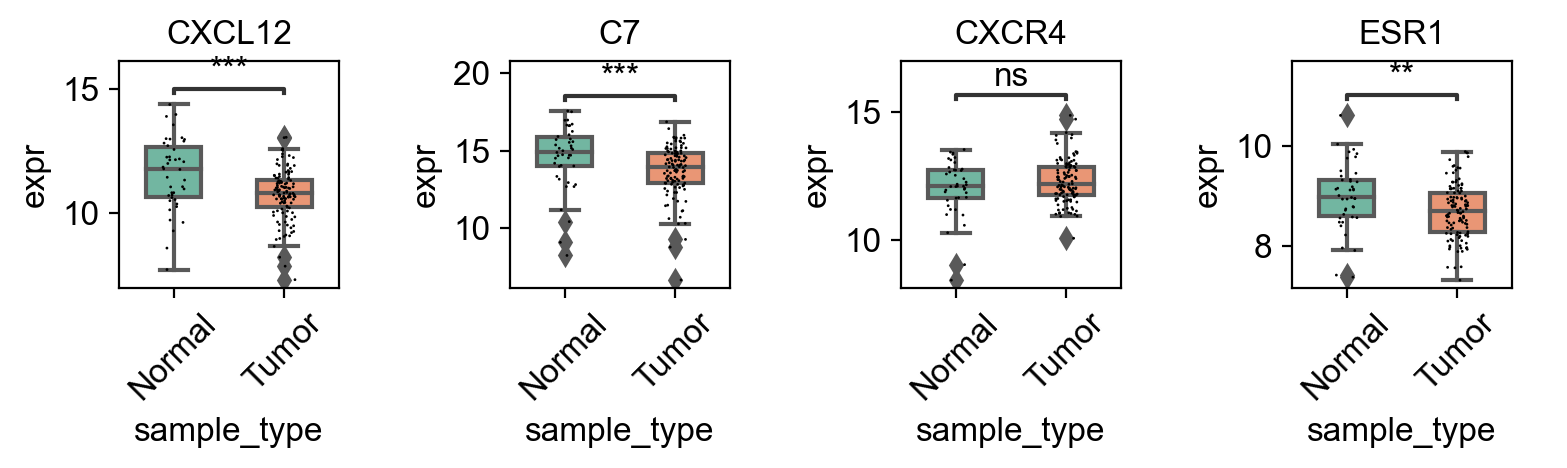

In [23]:
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind,mannwhitneyu
exp_mtx['sample_type'] = metadata['celltype']
exp_mtx_melt = exp_mtx.melt(id_vars=['sample_type'],var_name='gene',value_name='expr')
exp_mtx_melt['expr'] = exp_mtx_melt['expr'].astype(float)
exp_mtx_melt['sample_type'] = exp_mtx_melt['sample_type'].astype('category')
exp_mtx_melt['gene'] = exp_mtx_melt['gene'].astype('category')
# draw boxplot for each gene,add stripplot and t.test pvalue
fig, axs = plt.subplots(1,4,figsize=(8,2.5))
# for i, gene in enumerate(exp_mtx_melt['gene'].unique()):
for i, gene in enumerate(['CXCL12','C7','CXCR4','ESR1']):
    axs_tmp = axs[i%4]
    expr_tmp = exp_mtx_melt[exp_mtx_melt['gene'] == gene]
    plotting_parameters = {
        'data':    expr_tmp,
        'x':       'sample_type',
        'y':       'expr'
    }   
    group_data = expr_tmp['expr'][expr_tmp['sample_type'] =='tumor']
    other_group_data = expr_tmp['expr'][expr_tmp['sample_type'] =='normal']
    _, p_val = mannwhitneyu(group_data, other_group_data, alternative="two-sided")
    formatted_pvalues = [f'p={p_val:.2e}']
    pairs = [('normal', 'tumor')]
    sns.boxplot(**plotting_parameters,ax=axs_tmp, palette='Set2',width=0.5)
    annotator = Annotator(axs_tmp, pairs, **plotting_parameters)
    annotator.set_pvalues([p_val])
    # annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    sns.stripplot(**plotting_parameters, color="black", size=1,dodge=True,ax=axs_tmp)
    handles, labels = axs_tmp.get_legend_handles_labels()
    axs_tmp.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    labels_x = ['Normal','Tumor']
    axs_tmp.set_xticklabels(labels_x, rotation=45, ha='center')
    axs_tmp.set_title(gene, fontdict={'fontsize': 12, 'fontweight': 'medium'})
    axs_tmp.grid(False)
plt.tight_layout()
plt.savefig('CPTAC_PDAC_validation_genes.pdf')